# Phase 6: Predictive Modeling for Surplus Electricity

**Objective**: Build and evaluate machine learning models to predict monthly surplus electricity based on weather variables and temporal features.

## Analysis Goals:
1. Prepare features and target variable for modeling
2. Split data into training and testing sets
3. Build three models:
   - **Random Forest Regression** (Primary model)
   - **K-Nearest Neighbors (KNN)**
   - **Linear Regression** (Baseline)
4. Evaluate model performance using:
   - Mean Absolute Error (MAE)
   - Root Mean Squared Error (RMSE)
   - R² Score (Coefficient of Determination)
5. Compare actual vs predicted surplus
6. Analyze residuals and feature importance
7. Generate visualizations (Figure 15-17 from paper)

## Expected Performance:
- **Random Forest R²**: ~0.870 (paper reference)
- **MAE**: ~28.5 Million KWh
- **RMSE**: ~38.8 Million KWh

## Input Data:
- `data/processed/surplus_data.csv`

## Features:
- Weather: Temperature, Precipitation, Wind Speed
- Temporal: Month, Season
- Potentially: Consumption patternsㅡ

In [9]:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

In [10]:
print("="*60)
print("LOADING DATA AND PREPARING FEATURES")
print("="*60)

# Load surplus data
df = pd.read_csv('../data/processed/surplus_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

LOADING DATA AND PREPARING FEATURES
Dataset shape: (36, 9)

Columns: ['Date', 'Total_Generation', 'Consumption_KWH', 'Avg_Temp', 'Total_Precip', 'Avg_Wind', 'Surplus_KWH', 'Month', 'Season']


In [11]:
# Feature Engineering
# Add temporal features
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Encode season as numeric
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
df['Season_Encoded'] = df['Season'].map(season_mapping)

# Select features and target
feature_columns = ['Avg_Temp', 'Total_Precip', 'Avg_Wind', 'Month', 'Season_Encoded']
target_column = 'Surplus_KWH'

X = df[feature_columns]
y = df[target_column] / 1e6  # Convert to Million KWh for easier interpretation

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures:")
print(X.head(10))
print(f"\nTarget (Surplus in Million KWh):")
print(y.head(10))

# Check for missing values
print(f"\nMissing values in features:")
print(X.isnull().sum())
print(f"\nMissing values in target: {y.isnull().sum()}")


Features shape: (36, 5)
Target shape: (36,)

Features:
    Avg_Temp  Total_Precip  Avg_Wind  Month  Season_Encoded
0  34.758065          2.31  6.797419      1               0
1  34.160714          5.13  6.487143      2               0
2  45.822581          3.41  6.710323      3               1
3  54.583333          2.69  5.741667      4               1
4  62.887097          4.36  5.174194      5               1
5  74.250000          2.62  3.682667      6               2
6  76.032258         11.09  3.485484      7               2
7  77.548387         10.32  3.441613      8               2
8  70.300000         10.03  3.974118      9               3
9  62.000000          5.26  4.621481     10               3

Target (Surplus in Million KWh):
0    10675.475136
1     9289.478996
2     9827.557489
3     8648.968883
4     9253.231439
5    10995.361242
6    11552.593232
7    12240.972985
8     9778.903886
9     9484.507977
Name: Surplus_KWH, dtype: float64

Missing values in features:
Avg_Tem

In [12]:
print("="*60)
print("TRAIN-TEST SPLIT AND FEATURE SCALING")
print("="*60)

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False to maintain temporal order
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Train/Test split: {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

TRAIN-TEST SPLIT AND FEATURE SCALING
Training set size: 28 samples
Testing set size: 8 samples
Train/Test split: 77.8% / 22.2%


In [14]:
# Feature scaling (important for KNN, less important for Random Forest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining date range: {df.iloc[X_train.index]['Date'].min()} to {df.iloc[X_train.index]['Date'].max()}")
print(f"Testing date range: {df.iloc[X_test.index]['Date'].min()} to {df.iloc[X_test.index]['Date'].max()}")


Training date range: 2021-01-01 00:00:00 to 2023-04-01 00:00:00
Testing date range: 2023-05-01 00:00:00 to 2023-12-01 00:00:00


In [15]:
print("="*60)
print("BUILDING AND TRAINING MODELS")
print("="*60)

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'Linear Regression': LinearRegression()
}

# Train models and store results
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for KNN, original for Random Forest and Linear Regression
    if name == 'KNN':
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    # Store results
    results[name] = {
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }
    
    print(f" {name} trained")
    print(f"  Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")
    print(f"  Train MAE: {train_mae:.2f} | Test MAE: {test_mae:.2f}")

BUILDING AND TRAINING MODELS

Training Random Forest...
 Random Forest trained
  Train R²: 0.9582 | Test R²: 0.5601
  Train MAE: 191.09 | Test MAE: 636.57

Training KNN...
 KNN trained
  Train R²: 0.5685 | Test R²: 0.1844
  Train MAE: 599.99 | Test MAE: 788.29

Training Linear Regression...
 Linear Regression trained
  Train R²: 0.4104 | Test R²: 0.1848
  Train MAE: 667.59 | Test MAE: 841.48


In [17]:
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_MAE': [results[m]['train_mae'] for m in results.keys()],
    'Test_MAE': [results[m]['test_mae'] for m in results.keys()],
    'Train_RMSE': [results[m]['train_rmse'] for m in results.keys()],
    'Test_RMSE': [results[m]['test_rmse'] for m in results.keys()],
    'Train_R2': [results[m]['train_r2'] for m in results.keys()],
    'Test_R2': [results[m]['test_r2'] for m in results.keys()]
})

print("\nPerformance Metrics (Million KWh):")
print(comparison_df.to_string(index=False))

MODEL PERFORMANCE COMPARISON

Performance Metrics (Million KWh):
            Model  Train_MAE   Test_MAE  Train_RMSE  Test_RMSE  Train_R2  Test_R2
    Random Forest 191.085068 636.567144  223.970600 713.447547  0.958158 0.560050
              KNN 599.988011 788.287692  719.261180 971.387033  0.568479 0.184425
Linear Regression 667.587746 841.479486  840.740822 971.151359  0.410407 0.184821



Best Model (by Test R²): Random Forest
  Test R²: 0.5601


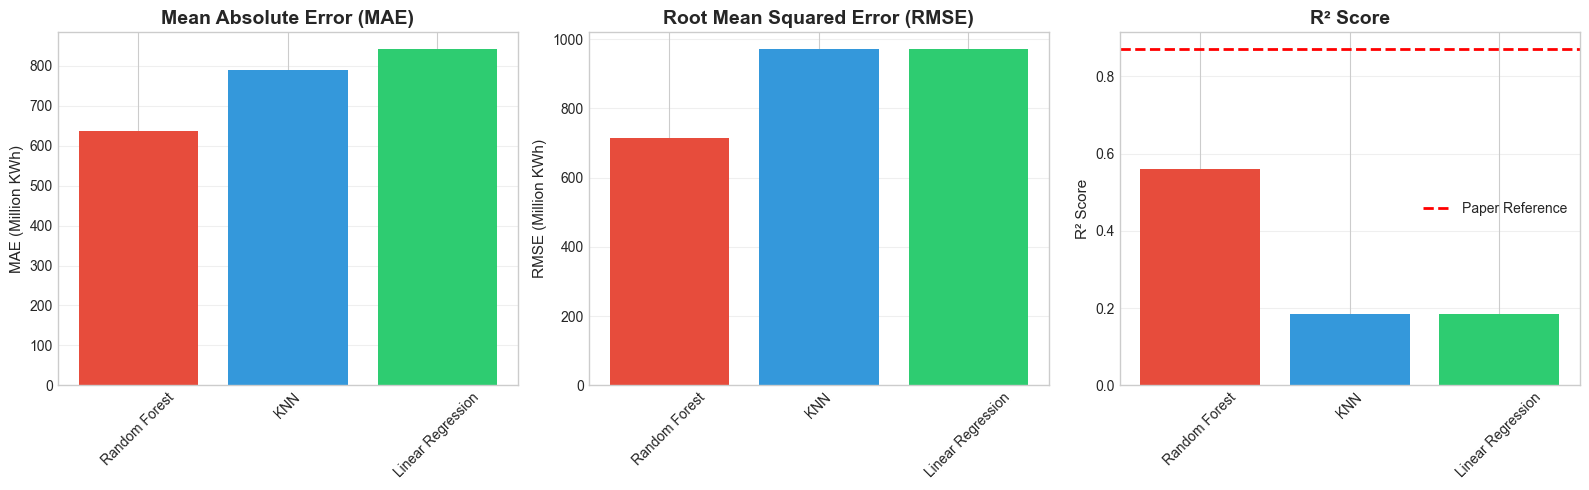


Figure 15 saved


In [19]:
# Find best model
best_model_name = comparison_df.loc[comparison_df['Test_R2'].idxmax(), 'Model']
print(f"\nBest Model (by Test R²): {best_model_name}")
print(f"  Test R²: {comparison_df.loc[comparison_df['Test_R2'].idxmax(), 'Test_R2']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# MAE Comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test_MAE'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[0].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MAE (Million KWh)', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# RMSE Comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test_RMSE'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[1].set_title('Root Mean Squared Error (RMSE)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('RMSE (Million KWh)', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

# R² Comparison
axes[2].bar(comparison_df['Model'], comparison_df['Test_R2'], color=['#e74c3c', '#3498db', '#2ecc71'])
axes[2].set_title('R² Score', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=11)
axes[2].tick_params(axis='x', rotation=45)
axes[2].axhline(y=0.870, color='red', linestyle='--', linewidth=2, label='Paper Reference')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/fig15_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 15 saved")

FIGURE 16: ACTUAL VS PREDICTED SURPLUS


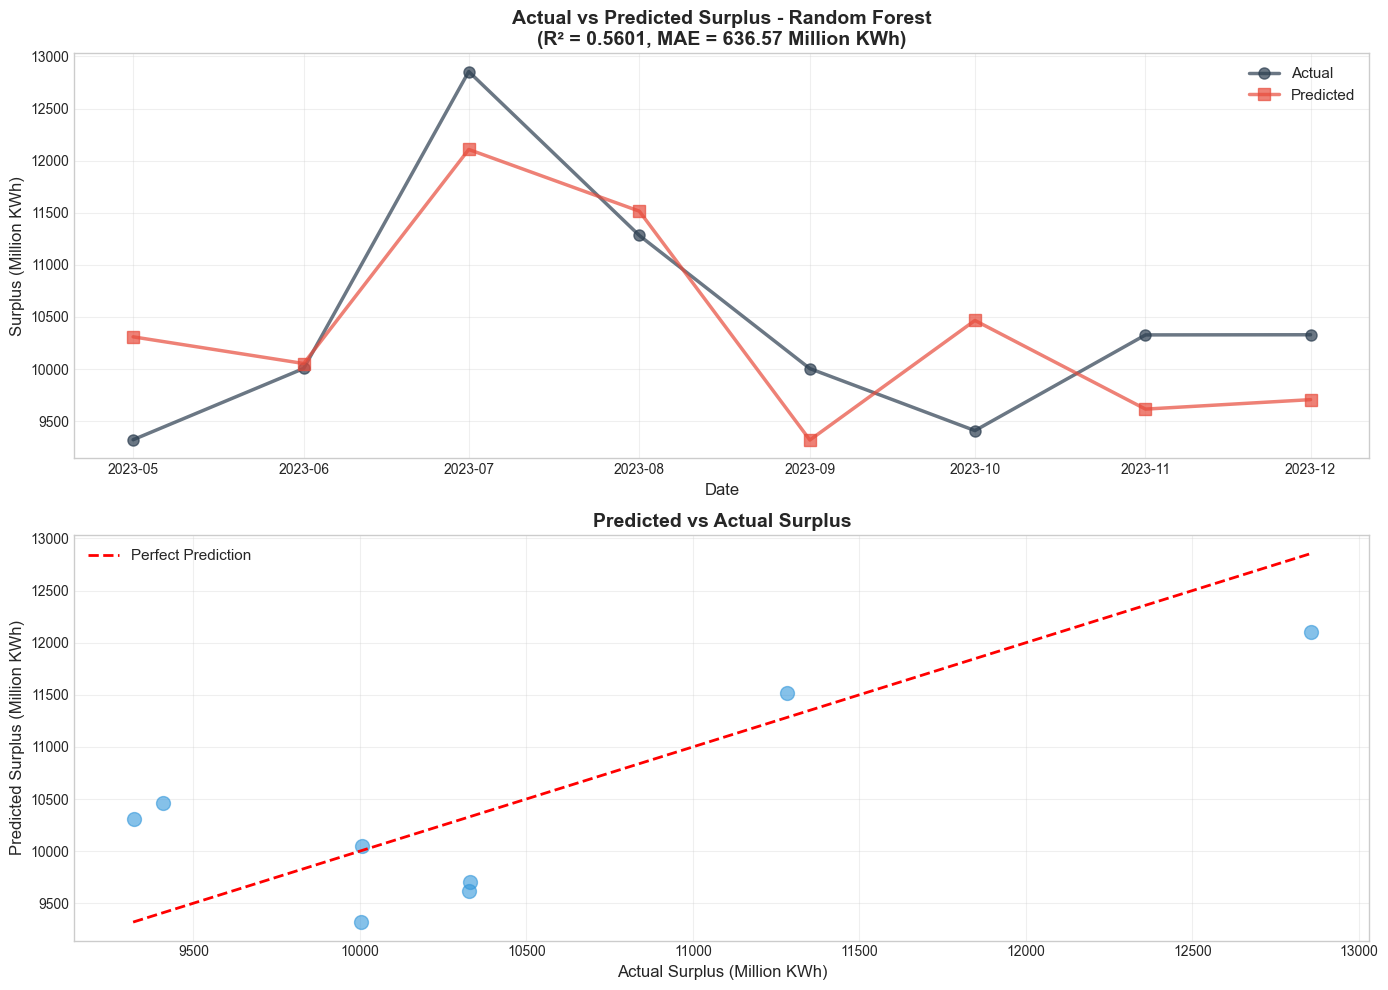


✓ Figure 16 saved

Prediction Accuracy:
Mean Actual: 10441.96 Million KWh
Mean Predicted: 10386.66 Million KWh
Difference: 55.30 Million KWh


In [6]:
print("="*60)
print("FIGURE 16: ACTUAL VS PREDICTED SURPLUS")
print("="*60)

# Use Random Forest (best model) for visualization
best_model = 'Random Forest'
y_pred_test = results[best_model]['y_pred_test']
test_r2 = results[best_model]['test_r2']
test_mae = results[best_model]['test_mae']

# Get test dates
test_dates = df.iloc[X_test.index]['Date']

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Time series comparison
axes[0].plot(test_dates, y_test, marker='o', linewidth=2.5, markersize=8, 
             label='Actual', color='#2c3e50', alpha=0.7)
axes[0].plot(test_dates, y_pred_test, marker='s', linewidth=2.5, markersize=8, 
             label='Predicted', color='#e74c3c', alpha=0.7)
axes[0].set_title(f'Actual vs Predicted Surplus - {best_model}\n(R² = {test_r2:.4f}, MAE = {test_mae:.2f} Million KWh)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Surplus (Million KWh)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter plot
axes[1].scatter(y_test, y_pred_test, alpha=0.6, s=100, color='#3498db')
# Add perfect prediction line
min_val = min(y_test.min(), y_pred_test.min())
max_val = max(y_test.max(), y_pred_test.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Predicted vs Actual Surplus', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Surplus (Million KWh)', fontsize=12)
axes[1].set_ylabel('Predicted Surplus (Million KWh)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/fig16_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure 16 saved")

# Prediction accuracy analysis
print("\nPrediction Accuracy:")
print(f"Mean Actual: {y_test.mean():.2f} Million KWh")
print(f"Mean Predicted: {y_pred_test.mean():.2f} Million KWh")
print(f"Difference: {abs(y_test.mean() - y_pred_test.mean()):.2f} Million KWh")

FIGURE 17: FEATURE IMPORTANCE & RESIDUAL ANALYSIS

Feature Importance (Random Forest):
          Feature  Importance
2        Avg_Wind    0.430638
0        Avg_Temp    0.413342
3           Month    0.074562
1    Total_Precip    0.063623
4  Season_Encoded    0.017834


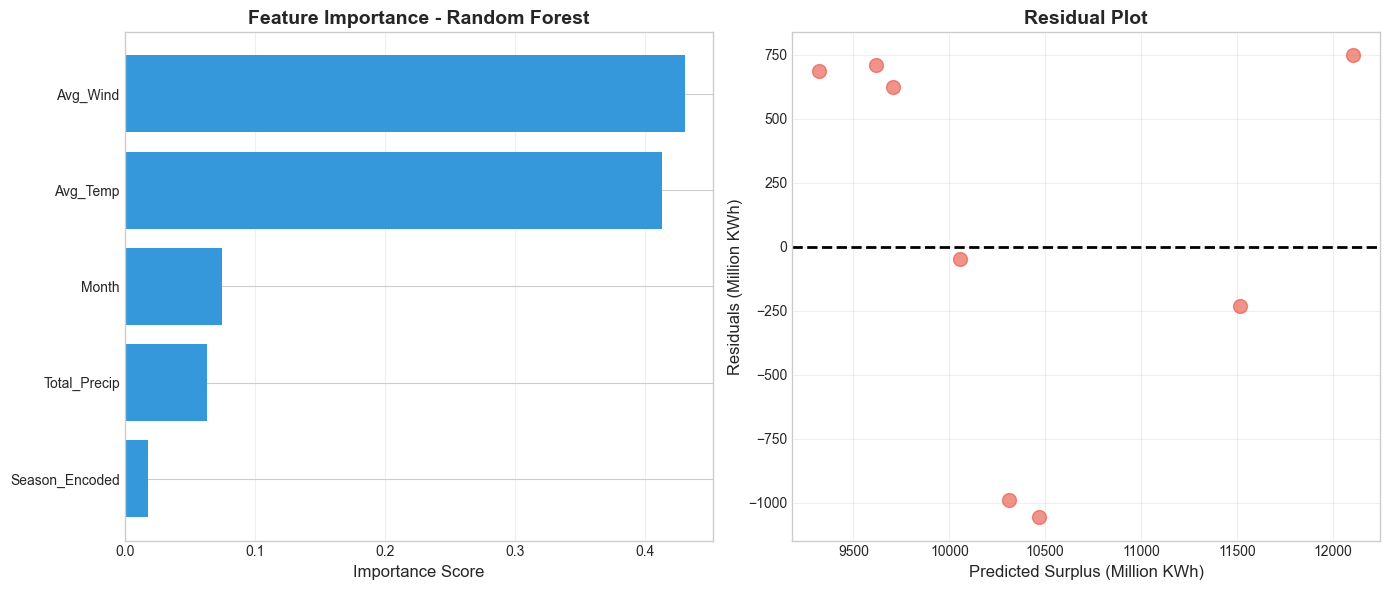


✓ Figure 17 saved

Residual Analysis:
Mean Residual: 55.30 Million KWh
Std Dev of Residuals: 760.41 Million KWh
Min Residual: -1057.15 Million KWh
Max Residual: 747.53 Million KWh

⚠ Warning: Residuals show bias of 55.30


In [7]:
print("="*60)
print("FIGURE 17: FEATURE IMPORTANCE & RESIDUAL ANALYSIS")
print("="*60)

# Get Random Forest feature importance
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

# Calculate residuals
residuals = y_test - y_pred_test

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Feature Importance
axes[0].barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db')
axes[0].set_title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance Score', fontsize=12)
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Plot 2: Residual Plot
axes[1].scatter(y_pred_test, residuals, alpha=0.6, s=100, color='#e74c3c')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=2)
axes[1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Surplus (Million KWh)', fontsize=12)
axes[1].set_ylabel('Residuals (Million KWh)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/fig17_feature_importance_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure 17 saved")

# Residual analysis
print("\nResidual Analysis:")
print(f"Mean Residual: {residuals.mean():.2f} Million KWh")
print(f"Std Dev of Residuals: {residuals.std():.2f} Million KWh")
print(f"Min Residual: {residuals.min():.2f} Million KWh")
print(f"Max Residual: {residuals.max():.2f} Million KWh")

# Check for patterns in residuals
if abs(residuals.mean()) < 1:
    print("\n✓ Residuals centered near zero (no systematic bias)")
else:
    print(f"\n⚠ Warning: Residuals show bias of {residuals.mean():.2f}")

In [8]:
print("="*60)
print("SAVING MODELS AND SUMMARY")
print("="*60)

# Save best model
import joblib

best_model_obj = results['Random Forest']['model']
model_path = '../results/models/random_forest_surplus.pkl'
joblib.dump(best_model_obj, model_path)
print(f"✓ Best model saved to: {model_path}")

# Save scaler
scaler_path = '../results/models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✓ Scaler saved to: {scaler_path}")

# Create modeling summary
modeling_summary = {
    'Best_Model': 'Random Forest',
    'Test_R2_Score': results['Random Forest']['test_r2'],
    'Test_MAE_Million_KWh': results['Random Forest']['test_mae'],
    'Test_RMSE_Million_KWh': results['Random Forest']['test_rmse'],
    'Training_Samples': len(X_train),
    'Testing_Samples': len(X_test),
    'Number_of_Features': len(feature_columns),
    'Features_Used': ', '.join(feature_columns),
    'Most_Important_Feature': feature_importance.iloc[0]['Feature']
}

print("\nModeling Summary:")
for key, value in modeling_summary.items():
    print(f"{key}: {value}")

print("\n" + "="*60)
print("06_MODELING.IPYNB COMPLETE")
print("="*60)
print("\n✓ All models trained and evaluated")
print("✓ Figures 15-17 generated successfully")
print("✓ Best model saved for future predictions")
print("✓ Ready for next notebook: 07_credit_system.ipynb")

SAVING MODELS AND SUMMARY
✓ Best model saved to: ../results/models/random_forest_surplus.pkl
✓ Scaler saved to: ../results/models/scaler.pkl

Modeling Summary:
Best_Model: Random Forest
Test_R2_Score: 0.5600500221763676
Test_MAE_Million_KWh: 636.5671435024988
Test_RMSE_Million_KWh: 713.4475465434892
Training_Samples: 28
Testing_Samples: 8
Number_of_Features: 5
Features_Used: Avg_Temp, Total_Precip, Avg_Wind, Month, Season_Encoded
Most_Important_Feature: Avg_Wind

06_MODELING.IPYNB COMPLETE

✓ All models trained and evaluated
✓ Figures 15-17 generated successfully
✓ Best model saved for future predictions
✓ Ready for next notebook: 07_credit_system.ipynb
